Prepare dataset and download models

In [8]:
!mkdir -p imgs && cp /kaggle/input/demo-imgs/* imgs/

In [9]:
!huggingface-cli download bartowski/nvidia_NVIDIA-Nemotron-Nano-9B-v2-GGUF nvidia_NVIDIA-Nemotron-Nano-9B-v2-Q8_0.gguf --local-dir . --local-dir-use-symlinks False

⚠️  Warning: 'huggingface-cli download' is deprecated. Use 'hf download' instead.
nvidia_NVIDIA-Nemotron-Nano-9B-v2-Q8_0.gguf


In [10]:
!ls .

imgs  llama-server  nvidia_NVIDIA-Nemotron-Nano-9B-v2-Q8_0.gguf


# GPU-Accelerated Data Science Agent Tutorial

Learn how to build an AI-powered data science agent with GPU acceleration.

## What You'll Learn

- Enable GPU acceleration with NVIDIA cuDF in just 2 lines of code
- Build an AI agent that writes Python code from natural language
- Perform interactive data analysis through conversational AI
- Execute large tabular data operations with GPU acceleration

## GPU Acceleration in Just 2 Lines of Code

### The Setup

Traditional pandas operations run on CPU. With NVIDIA's `cudf.pandas`, you get massive speedups without changing your code.

```python
import cudf.pandas
cudf.pandas.install()
```

After these two lines, your pandas code automatically runs on GPU when beneficial.

## What is the DataScienceAgent?

The **DataScienceAgent** combines:
- **Large Language Model (LLM)** - Understands natural language requests
- **Function Calling** - Executes Python code dynamically based on questions
- **GPU Acceleration** - Speeds up pandas operations using NVIDIA GPUs

**Key Features:**
- Natural language interface - ask questions in plain English
- GPU-accelerated pandas operations for fast data analysis
- Persistent execution environment - variables carry over between requests
- Smart error recovery - automatically fixes and retries failed code
- Automatic data visualization support

### NVIDIA Nemotron: The Model Behind the Agent

The DataScienceAgent uses **NVIDIA Nemotron-9B-v2**, a language model optimized for:

- Function calling and structured output
- Python code generation and data analysis tasks
- Efficiency - runs locally on consumer GPUs
- Accuracy - competitive with larger models on specific tasks

In [11]:
!cp /kaggle/input/llamacpp-sm75-complete-build/build/bin/llama-server ./ && chmod +x llama-server

cp: cannot create regular file './llama-server': Text file busy


In [12]:
import subprocess
import os

# Set environment variable
env = os.environ.copy()
env['LD_LIBRARY_PATH'] = f"/kaggle/input/llamacpp-sm75-complete-build/build/bin:{env.get('LD_LIBRARY_PATH', '')}"

# Run the command
process = subprocess.Popen([
    './llama-server',
    '-m', '/kaggle/working/nvidia_NVIDIA-Nemotron-Nano-9B-v2-Q8_0.gguf',
    '--host', '0.0.0.0',
    '--port', '8000',
    '-ngl', '99',
    '--ctx-size', '8192',
    '--n-predict', '2048',
    '--threads', '8',
    '--batch-size', '128',
    '--ubatch-size', '128',
    '--cache-reuse', '256',
    '--flash-attn', 'on',
    '--reasoning-format', 'none', 
    '--chat-template-file', '/kaggle/input/democode/chat-template-no-think.jinja',
    '--jinja'
], env=env)

In [13]:
import time
time.sleep(120) # wait for llm server to come online

## Initialize the Agent

Initialize the DataScienceAgent with the local Nemotron server.

In [14]:
import sys
sys.path.append('/kaggle/input/democode')
from agent import DataScienceAgent
try:
    #agent = DataScienceAgent(verbose=True, force_final_response_after_success=True)
    agent = DataScienceAgent(verbose=True, stream=True, skip_final_response=True)
    print("\nUsing local Nemotron server at http://localhost:8000")
    print("Make sure the server is running with: ./start-nemotron-server.sh\n")
    print("Agent ready! Type your questions in the cells below.\n")
except Exception as e:
    print(f"Error initializing agent: {e}")
    print("\nMake sure the local LLM server is running.")
    print("To use NVIDIA cloud API instead, modify agent initialization in this cell")

[GPU Acceleration] cudf.pandas initialized successfully
DataScienceAgent initialized
  Base URL: http://localhost:8000/v1
  Model: nemotron
  Available tools: ['execute_python_code']


Using local Nemotron server at http://localhost:8000
Make sure the server is running with: ./start-nemotron-server.sh

Agent ready! Type your questions in the cells below.



### How the Agent Works

The agent has the following capabilities:

**Tools Available:**
- `execute_python_code` - Writes and runs pandas code with GPU acceleration

**Intelligence:**
- Understands natural language questions about data
- Automatically generates appropriate pandas code with GPU acceleration
- Handles errors gracefully and retries with corrections
- Remembers context across the conversation

**Persistent Memory:**
- Variables (like dataframes) persist between requests
- Build on previous work without re-loading data
- Example: Load data in one request, analyze it in the next

**Performance:**
- GPU acceleration automatically enabled for pandas operations
- Falls back to CPU if GPU operations aren't supported
- Execution time tracking for performance monitoring

## Helper Functions

In [15]:
def reset_conversation():
    """Reset the conversation history."""
    agent.reset_conversation()
    print("✅ Conversation reset. Starting fresh!")

def ask(prompt):
    """Ask the agent a question and get a response."""
    print(f"💬 You: {prompt}\n")
    print("🤖 Agent:")

    # ANSI color codes
    BOLD = '\033[1m'
    GREEN = '\033[92m'
    CYAN = '\033[96m'
    RED = '\033[91m'
    YELLOW = '\033[93m'
    MAGENTA = '\033[95m'
    BLUE = '\033[94m'
    RESET = '\033[0m'

    try:
        # For streaming mode: let output appear in real-time, then highlight [TOOL OUTPUT]
        if agent.stream:
            import io
            import sys
            from IPython.display import display, HTML
            
            # Capture output to post-process for highlighting
            stdout_buffer = io.StringIO()
            old_stdout = sys.stdout
            
            # Use a custom writer that prints immediately AND captures
            class TeeWriter:
                def __init__(self, *writers):
                    self.writers = writers
                
                def write(self, text):
                    for writer in self.writers:
                        writer.write(text)
                    return len(text)
                
                def flush(self):
                    for writer in self.writers:
                        writer.flush()
            
            sys.stdout = TeeWriter(old_stdout, stdout_buffer)
            response = agent.process_prompt(prompt)
            sys.stdout = old_stdout
            
            # Get captured output and apply highlighting to [TOOL OUTPUT] section
            output = stdout_buffer.getvalue()
            #print(output)
            #output = response
            
            # Only re-print the TOOL OUTPUT section with colors
            if True:
                output = '[Agent Response]\n'+response
                lines = output.split('\n')
                in_tool_output = False
                
                for i, line in enumerate(lines):
                    if '[Agent Response]' in line:
                        # Clear the plain [TOOL OUTPUT] and print colored version
                        print(f"\r{BOLD}{MAGENTA}[Agent Response]{RESET}")
                        in_tool_output = True
                    elif in_tool_output and line.strip().startswith('----------------------------------------------------------------------'):
                        print(f"\r{MAGENTA}{line}{RESET}")
                        if i > 0 and not any('[Agent Response]' in lines[j] for j in range(max(0, i-5), i)):
                            in_tool_output = False
                    elif in_tool_output and line.strip() and not line.strip().startswith('----------------------------------------------------------------------'):
                        print(f"\r{GREEN}{line}{RESET}")
            
        else:
            # Non-streaming mode: capture and format output
            import io
            import sys
            
            stdout_buffer = io.StringIO()
            stderr_buffer = io.StringIO()
            
            old_stdout = sys.stdout
            old_stderr = sys.stderr
            
            sys.stdout = stdout_buffer
            sys.stderr = stderr_buffer
            response = agent.process_prompt(prompt)
            sys.stdout = old_stdout
            sys.stderr = old_stderr
            
            # Get the captured output
            output = stdout_buffer.getvalue()
            errors = stderr_buffer.getvalue()
            
            # Add emoji indicators and formatting to execution results
            lines = output.split('\n')
            formatted_lines = []
            in_response_section = False
            
            for line in lines:
                # Highlight AGENT RESPONSE section
                if '[AGENT RESPONSE]' in line:
                    formatted_lines.append(f"{BOLD}{CYAN}[AGENT RESPONSE]{RESET}")
                    in_response_section = True
                elif in_response_section and '----------------------------------------------------------------------' in line:
                    formatted_lines.append(f"{CYAN}{line}{RESET}")
                elif in_response_section and line.strip() and '----------------------------------------------------------------------' not in line and '[' not in line:
                    # This is the actual response content
                    formatted_lines.append(f"{BOLD}{GREEN}{line}{RESET}")
                # Add success/failure indicators
                elif "'success': True" in line or '"success": true' in line:
                    formatted_lines.append(f"✅ {line}")
                    in_response_section = False
                elif "'success': False" in line or '"success": false' in line:
                    formatted_lines.append(f"❌ {line}")
                    in_response_section = False
                else:
                    formatted_lines.append(line)
                    if line.strip() == '':
                        in_response_section = False
            
            print('\n'.join(formatted_lines))
            if errors:
                import sys
                print(errors, file=sys.stderr)
        
        # Display context token information (works for all modes)
        context_info = agent.get_context_tokens()
        print(f"\n{BOLD}{YELLOW}📊 Context Usage:{RESET}")
        print(f"  Messages: {context_info['message_count']}")
        print(f"  Total tokens: ~{context_info['total_tokens']:,}")
        print(f"  Breakdown: System={context_info['breakdown_tokens']['system']}, "
              f"User={context_info['breakdown_tokens']['user']}, "
              f"Assistant={context_info['breakdown_tokens']['assistant']}, "
              f"Tool={context_info['breakdown_tokens']['tool']}")

    except Exception as e:
        print(f"❌ Error: {e}")
        raise

    #return response

### About the Helper Functions

The cell above defined two convenience functions:

**`reset_conversation()`**
- Clears the conversation history
- Resets the execution environment (removes all variables)
- Useful when starting a fresh analysis

**`ask(prompt)`**
- Main interface for chatting with the agent
- Sends your question to the agent
- Displays formatted responses with color coding:
  - Green = Successful execution
  - Red = Errors
  - Yellow = Context usage statistics
- Shows token usage to monitor context window

## Interactive Chat

Run the cells below to interact with the agent. Modify the prompt text or duplicate cells to ask multiple questions.

In [16]:
1

1

In [17]:
reset_conversation()

Conversation and execution environment reset.
  All variables cleared from execution environment.
✅ Conversation reset. Starting fresh!


In [18]:
ask("Read /kaggle/input/lending-club/loan.csv what are the column names?")

💬 You: Read /kaggle/input/lending-club/loan.csv what are the column names?

🤖 Agent:
USER PROMPT: Read /kaggle/input/lending-club/loan.csv what are the column names?


  Calling: execute_python_code{"code":"print(df.columns.tolist())"}
  -> Calling tool: execute_python_code
    use_gpu: True
    code:
      print(df.columns.tolist())
{
  "success": false,
  "mode": "gpu_accelerated",
  "error": "name 'df' is not defined",
  "error_type": "NameError"
}

  Calling: execute_python_code{"code":"import pandas as pd\n\n# Read the CSV file\nfile_path = '/kaggle/input/lending-club/loan.csv'\ndf = pd.read_csv(file_path)\n\n# Print column names\nprint(df.columns.tolist())"}
  -> Calling tool: execute_python_code
    use_gpu: True
    code:
      import pandas as pd
      
      # Read the CSV file
      file_path = '/kaggle/input/lending-club/loan.csv'
      df = pd.read_csv(file_path)
      
      # Print column names
      print(df.columns.tolist())
{
  "success": true,
  "mode": "gpu_accelera

In [19]:
%%time

ask("how many rows and columns are there?")

💬 You: how many rows and columns are there?

🤖 Agent:
USER PROMPT: how many rows and columns are there?

  Streaming response: The DataFrame has 39,717 rows and 111 columns.

[AGENT RESPONSE]
----------------------------------------------------------------------
The DataFrame has 39,717 rows and 111 columns.
----------------------------------------------------------------------

[Agent Response]
The DataFrame has 39,717 rows and 111 columns.

📊 Context Usage:
  Messages: 4
  Total tokens: ~161
  Breakdown: System=124, User=25, Assistant=11, Tool=0
CPU times: user 33.2 ms, sys: 6.83 ms, total: 40 ms
Wall time: 3.44 s


In [20]:
%%time

ask("show me the first 5 rows")

💬 You: show me the first 5 rows

🤖 Agent:
USER PROMPT: show me the first 5 rows


  Calling: execute_python_code{"code":"print(df.head())"}
  -> Calling tool: execute_python_code
    use_gpu: True
    code:
      print(df.head())
{
  "success": true,
  "mode": "gpu_accelerated",
  "execution_time_seconds": 0.1788
}
[Agent Response]
        id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  1077501    1296599       5000         5000           4975.0   36 months   
1  1077430    1314167       2500         2500           2500.0   60 months   
2  1077175    1313524       2400         2400           2400.0   36 months   
3  1076863    1277178      10000        10000          10000.0   36 months   
4  1075358    1311748       3000         3000           3000.0   60 months   
  int_rate  installment grade sub_grade  ... num_tl_90g_dpd_24m  \
0   10.65%       162.87     B        B2  ...               <NA>   
1   15.27%        59.83     C        C4  ...               <NA> 

💬 You: Plot number of columns distributed by Data Types, number in x axis and datatype in y axis

🤖 Agent:
USER PROMPT: Plot number of columns distributed by Data Types, number in x axis and datatype in y axis


  Calling: execute_python_code{"code":"import matplotlib.pyplot as plt\n\n# Get the count of columns for each data type\ncol_dtypes = df.dtypes.value_counts()\n\n# Plot the distribution\nplt.figure(figsize=(10, 6))\nplt.barh(col_dtypes.index.astype(str), col_dtypes.values)\nplt.xlabel('Number of Columns')\nplt.ylabel('Data Type')\nplt.title('Number of Columns by Data Type')\nplt.tight_layout()\nplt.show()","use_gpu":false}
  -> Calling tool: execute_python_code
    use_gpu: False
    code:
      import matplotlib.pyplot as plt
      
      # Get the count of columns for each data type
      col_dtypes = df.dtypes.value_counts()
      
      # Plot the distribution
      plt.figure(figsize=(10, 6))
      plt.barh(col_dtypes.index.astype(str), col_dtypes.values)
      plt.xlabel(

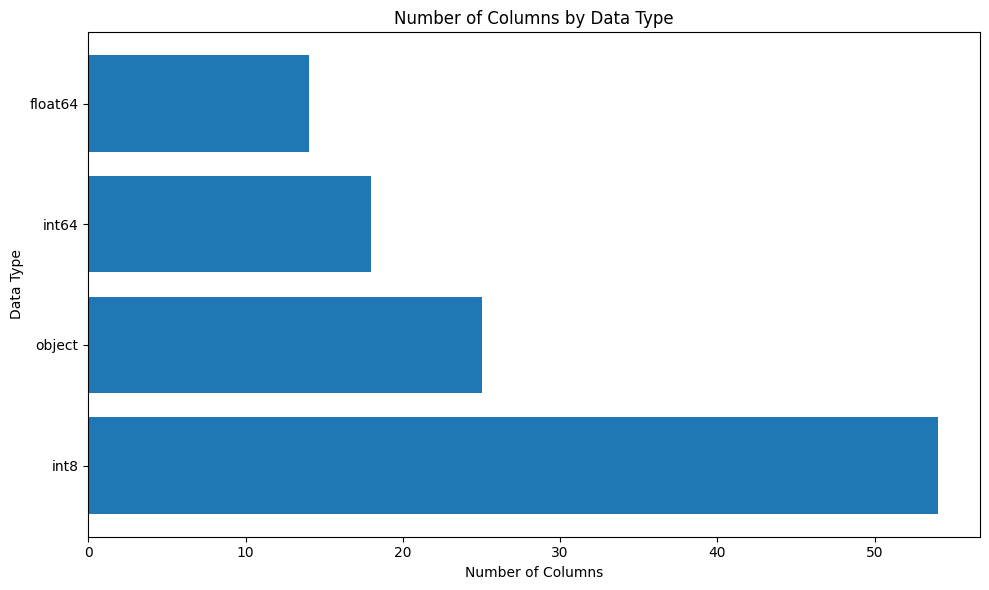

{
  "success": true,
  "mode": "gpu_accelerated",
  "execution_time_seconds": 0.1571
}
No output from execution, exiting
[Agent Response]

📊 Context Usage:
  Messages: 11
  Total tokens: ~1,137
  Breakdown: System=124, User=71, Assistant=327, Tool=615
CPU times: user 308 ms, sys: 30.9 ms, total: 339 ms
Wall time: 6.67 s


In [22]:
%%time

ask("Plot number of columns distributed by Data Types, number in x axis and datatype in y axis")

In [23]:
%%time

ask("Remove the columns which have higher percentage of missing values say more than 90%")

💬 You: Remove the columns which have higher percentage of missing values say more than 90%

🤖 Agent:
USER PROMPT: Remove the columns which have higher percentage of missing values say more than 90%


  Calling: execute_python_code{"code":"missing_percent = df.isnull().mean() * 100\ncols_to_drop = missing_percent[missing_percent > 90].index\nprint(f'Columns to drop: {cols_to_drop.tolist()}')\ndf = df.drop(columns=cols_to_drop)\nprint(f'Shape after dropping: {df.shape}')","use_gpu":true}
  -> Calling tool: execute_python_code
    use_gpu: True
    code:
      missing_percent = df.isnull().mean() * 100
      cols_to_drop = missing_percent[missing_percent > 90].index
      print(f'Columns to drop: {cols_to_drop.tolist()}')
      df = df.drop(columns=cols_to_drop)
      print(f'Shape after dropping: {df.shape}')
{
  "success": true,
  "mode": "gpu_accelerated",
  "execution_time_seconds": 0.2409
}
    DataFrames modified: df
[Agent Response]
Columns to drop: ['mths_since_last_record', 'next

In [24]:
%%time
ask("what are the column available in dataframe?")

💬 You: what are the column available in dataframe?

🤖 Agent:
USER PROMPT: what are the column available in dataframe?


  Calling: execute_python_code{"code":"print(df.columns.tolist())"}
  -> Calling tool: execute_python_code
    use_gpu: True
    code:
      print(df.columns.tolist())
{
  "success": true,
  "mode": "gpu_accelerated",
  "execution_time_seconds": 0.0083
}
[Agent Response]
['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recove

In [25]:
%%time
ask("shape of the dataframe")

💬 You: shape of the dataframe

🤖 Agent:
USER PROMPT: shape of the dataframe


  Calling: execute_python_code{"code":"print(df.shape)"}
  -> Calling tool: execute_python_code
    use_gpu: True
    code:
      print(df.shape)
{
  "success": true,
  "mode": "gpu_accelerated",
  "execution_time_seconds": 0.0067
}
[Agent Response]
(39717, 55)

📊 Context Usage:
  Messages: 20
  Total tokens: ~2,207
  Breakdown: System=124, User=108, Assistant=506, Tool=1468
CPU times: user 32.8 ms, sys: 7.99 ms, total: 40.8 ms
Wall time: 2.48 s


In [26]:
%%time
ask("Drop the columns which does not provide any meaning to EDA analysis")

💬 You: Drop the columns which does not provide any meaning to EDA analysis

🤖 Agent:
USER PROMPT: Drop the columns which does not provide any meaning to EDA analysis


  Calling: execute_python_code{"code":"df = df.drop(columns=['emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d', 'collections_12_mths_ex_med', 'policy_code', 'application_type', 'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt', 'pub_rec_bankruptcies', 'tax_liens'])","use_gpu":true}
  -> Calling to

In [27]:
%%time
ask("columns in the dataframe")

💬 You: columns in the dataframe

🤖 Agent:
USER PROMPT: columns in the dataframe


  Calling: execute_python_code{"code":"print(df.columns.tolist())"}
  -> Calling tool: execute_python_code
    use_gpu: True
    code:
      print(df.columns.tolist())
{
  "success": true,
  "mode": "gpu_accelerated",
  "execution_time_seconds": 0.0124
}
[Agent Response]
['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade']

📊 Context Usage:
  Messages: 25
  Total tokens: ~2,702
  Breakdown: System=124, User=130, Assistant=778, Tool=1669
CPU times: user 47.3 ms, sys: 9.7 ms, total: 57 ms
Wall time: 7.71 s


In [28]:
%%time
ask("loan_status was needed as the target column, is there a way to add them back to dataframe? ")

💬 You: loan_status was needed as the target column, is there a way to add them back to dataframe? 

🤖 Agent:
USER PROMPT: loan_status was needed as the target column, is there a way to add them back to dataframe? 


  Calling: execute_python_code{"code":"df['loan_status'] = df_original['loan_status']","use_gpu":true}
  -> Calling tool: execute_python_code
    use_gpu: True
    code:
      df['loan_status'] = df_original['loan_status']
{
  "success": false,
  "mode": "gpu_accelerated",
  "error": "name 'df_original' is not defined",
  "error_type": "NameError"
}

  Calling: execute_python_code{"code":"df['loan_status'] = df_original['loan_status']","use_gpu":true}
  -> Calling tool: execute_python_code
    use_gpu: True
    code:
      df['loan_status'] = df_original['loan_status']
{
  "success": false,
  "mode": "gpu_accelerated",
  "error": "name 'df_original' is not defined",
  "error_type": "NameError"
}
  Streaming response: The variable 'df_original' is not available in the curren

In [29]:
%%time
ask("please load the orginal dataset and take the loan_status from there")

💬 You: please load the orginal dataset and take the loan_status from there

🤖 Agent:
USER PROMPT: please load the orginal dataset and take the loan_status from there


  Calling: execute_python_code{"code":"import pandas as pd\n# Reload the original dataset\noriginal_df = pd.read_csv('/kaggle/input/lending-club/loan.csv')\n# Add loan_status back to the current df\ndf['loan_status'] = original_df['loan_status']\nprint(f'Shape after adding loan_status: {df.shape}')","use_gpu":true}
  -> Calling tool: execute_python_code
    use_gpu: True
    code:
      import pandas as pd
      # Reload the original dataset
      original_df = pd.read_csv('/kaggle/input/lending-club/loan.csv')
      # Add loan_status back to the current df
      df['loan_status'] = original_df['loan_status']
      print(f'Shape after adding loan_status: {df.shape}')
{
  "success": true,
  "mode": "gpu_accelerated",
  "execution_time_seconds": 0.0804
}
    DataFrames created: original_df
    DataFrames modified: df
[Agen

In [30]:
%%time
ask("what is the currect column in the dataframe? ")

💬 You: what is the currect column in the dataframe? 

🤖 Agent:
USER PROMPT: what is the currect column in the dataframe? 


  Calling: execute_python_code{"code":"print(df.columns.tolist())"}
  -> Calling tool: execute_python_code
    use_gpu: True
    code:
      print(df.columns.tolist())
{
  "success": true,
  "mode": "gpu_accelerated",
  "execution_time_seconds": 0.0162
}
[Agent Response]
['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'loan_status']

📊 Context Usage:
  Messages: 31
  Total tokens: ~3,237
  Breakdown: System=124, User=181, Assistant=944, Tool=1987
CPU times: user 58.6 ms, sys: 8.94 ms, total: 67.6 ms
Wall time: 8.75 s


💬 You: perform Univariate Analysis on the datafram with necessary plots 

🤖 Agent:
USER PROMPT: perform Univariate Analysis on the datafram with necessary plots 


  Calling: execute_python_code{"code":"import matplotlib.pyplot as plt\nimport seaborn as sns\n\n# Univariate Analysis\n\n# 1. Loan Amount Distribution\nplt.figure(figsize=(10, 6))\nsns.histplot(df['loan_amnt'], bins=50, kde=True)\nplt.title('Loan Amount Distribution')\nplt.xlabel('Loan Amount')\nplt.ylabel('Frequency')\nplt.show()\n\n# 2. Interest Rate Distribution\nplt.figure(figsize=(10, 6))\nsns.histplot(df['int_rate'], bins=50, kde=True)\nplt.title('Interest Rate Distribution')\nplt.xlabel('Interest Rate')\nplt.ylabel('Frequency')\nplt.show()\n\n# 3. Installment Distribution\nplt.figure(figsize=(10, 6))\nsns.histplot(df['installment'], bins=50, kde=True)\nplt.title('Installment Distribution')\nplt.xlabel('Installment')\nplt.ylabel('Frequency')\nplt.show()\n\n# 4. Loan Term Distribution\nplt.figure(figsize=(10, 6))\nsns.

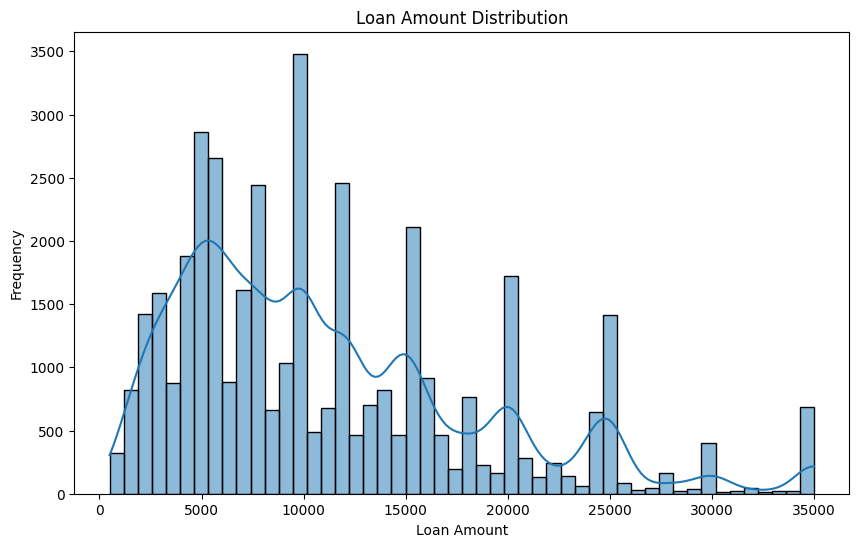

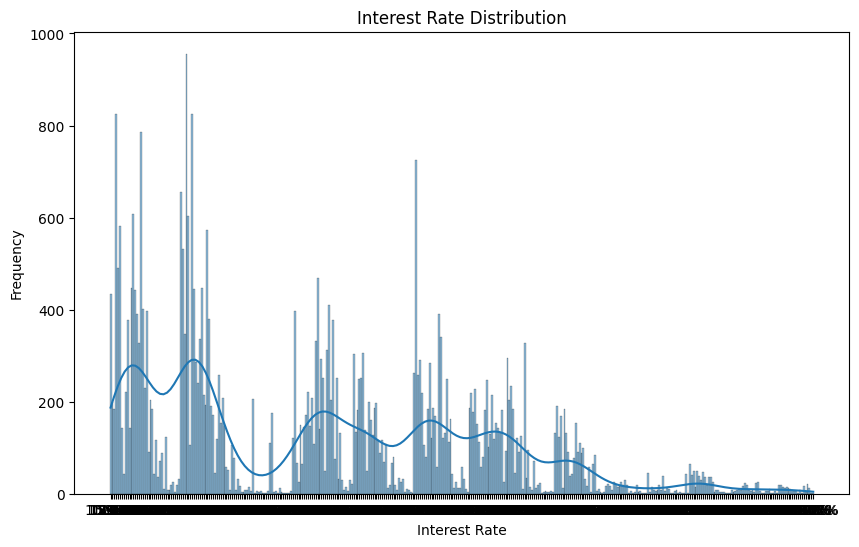

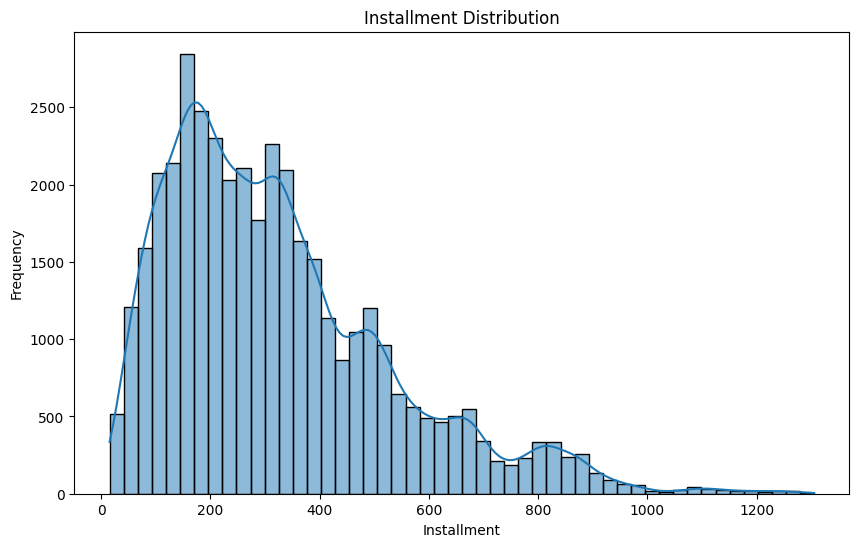

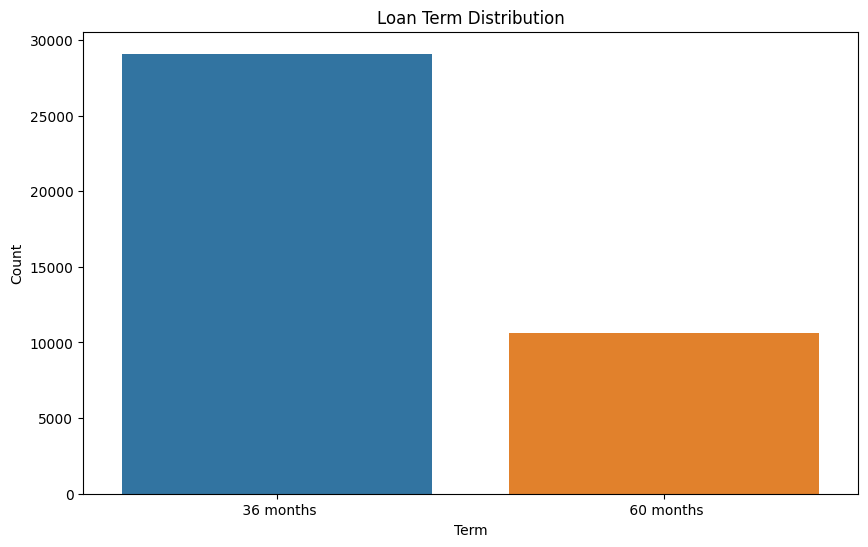

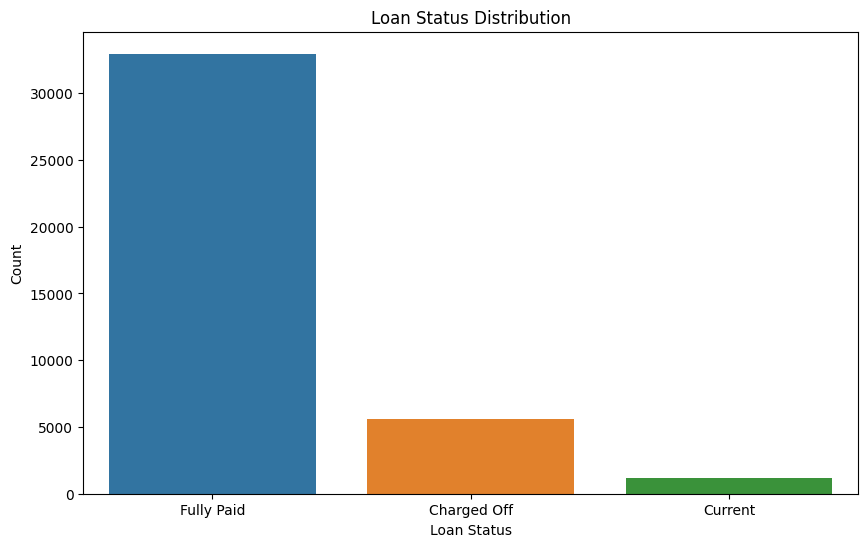

{
  "success": true,
  "mode": "gpu_accelerated",
  "execution_time_seconds": 10.3044
}
No output from execution, exiting
[Agent Response]

📊 Context Usage:
  Messages: 33
  Total tokens: ~3,581
  Breakdown: System=124, User=197, Assistant=1271, Tool=1987
CPU times: user 10.5 s, sys: 606 ms, total: 11.1 s
Wall time: 35.5 s


In [32]:
%%time
ask("perform Univariate Analysis on the datafram with necessary plots ")

## What You Just Learned

You've built a GPU-accelerated data science agent!

### Key Points

**GPU Acceleration** - Just 2 lines:
```python
import cudf.pandas
cudf.pandas.install()
```

**Natural Language Analysis**
- Ask questions in plain English
- Agent writes and executes pandas code automatically
- Variables persist across conversations

**Performance** - GPU speeds up operations on large datasets with no code changes

### Try It Yourself

1. Duplicate any chat cell above
2. Ask your own questions
3. Load your own CSV files
4. Check `agent.py` and `tools.py` to see the implementation

**Remember:** GPU acceleration + LLM function calling = powerful interactive data analysis

In [26]:
import psutil
import os
import signal

def kill_child_processes(parent_pid=None, sig=signal.SIGTERM):
    if parent_pid is None:
        parent_pid = os.getpid()
    try:
        parent = psutil.Process(parent_pid)
    except psutil.NoSuchProcess:
        return
    for child in parent.children(recursive=True):
        try:
            child.send_signal(sig)
        except Exception:
            pass

# Call this at the end of your notebook
kill_child_processes()
import atexit

atexit.register(kill_child_processes)

<function __main__.kill_child_processes(parent_pid=None, sig=<Signals.SIGTERM: 15>)>